# Browsing History [A Visualization Exercise]

In [1]:
# Import scripts
%matplotlib inline
import pandas as pd
import numpy as np
import json
import datetime
import tldextract
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
plt.style.use('fivethirtyeight')

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [3]:
# Create dataframe from browser data
with open('BrowserHistory.json', 'r', encoding='utf-8') as f:
    data = json.load(f)
    df = pd.DataFrame(data['Browser History'])

# Data Cleaning

In [4]:
# Remove unnecessary columns  
df.drop('client_id', axis=1, inplace=True)
df.drop('favicon_url', axis=1, inplace=True)

In [5]:
# PAGE-TRANSITION TYPE DEFINITION:
# AUTO_BOOKMARK    User got to this page through a suggestion in the UI.
# AUTO_TOPLEVEL    This is any content that is automatically loaded in a toplevel frame. (ie. homescreen / splash page)
# FORM_SUBMIT      The user filled out values in a form and submitted it.
# GENERATED        User got to this page by typing in the URL bar and selecting an entry that did not look like a URL.
# KEYWORD          The url was generated from a replaceable keyword other than the default search provider.
# LINK             User got to this page by clicking a link on another page.
# RELOAD           The user "reloaded" the page, either by hitting the reload button or by hitting enter in the address bar. 
#                  SessionRestore and undo tab close use this transition type too.
# TYPED            User got this page by typing the URL in the URL bar.

df.groupby(['page_transition']).size()

page_transition
AUTO_BOOKMARK      3336
AUTO_TOPLEVEL      1335
FORM_SUBMIT        5243
GENERATED          5385
KEYWORD              10
LINK             121934
RELOAD             8137
TYPED             11032
dtype: int64

In [6]:
# Convert time_usec to readable datetime format
# Added columns to break out datetime
df['time_usec'] = pd.to_datetime(df['time_usec'],unit='us', utc=True)
df['PST_time'] = df['time_usec'].dt.tz_localize('UTC').dt.tz_convert('America/Vancouver')
df['month'] = df['PST_time'].dt.month
df['hour'] = df['PST_time'].dt.hour
df['day_of_week'] = df['PST_time'].dt.weekday_name
df['weekday'] = df['PST_time'].apply(lambda x: "Y" if x.weekday()<5 else "N")

In [7]:
# Parse URL to get domain information
def get_domain(x):
    if x.startswith('chrome-extension://'):
        return "chrome_extension"
    domain = tldextract.extract(x)[1]
    sub_domain = tldextract.extract(x)[0]
    if domain == "google":
        if sub_domain=="www":
            return "google_search"
        else:
            return sub_domain + "." + domain
    return domain
df['domain'] = df['url'].apply(get_domain)

In [8]:
# Create website categories
def get_category(x):
    if x in ["github", "codecademy", "springboard", "brainstation", "ubc", "coursera", 
             "localhost", "tilda", "getbootstrap", "codeskulptor", "w3schools", "thenounproject", "fontawesome"]:
        return "Coding"
    elif x in ["mail.google", "slack"]:
        return "Email"
    elif x in ["hsbc", "mbna", "americanexpress"]:
        return "Finance"
    elif x in ["vul", "meetup", "eventbrite", "shockwave", "sporcle"]:
        return "Fun"
    elif x in ["linkedin", "angel", "lever", "indeed", "taleo", "ventureloop", "greenhouse"]:
        return "Job"
    elif x in ["feedly", "producthunt","themuse", "medium", "cbc", "techvibes"]:
        return "News"
    elif x in ["toggl", "trello", "calendar.google", "wrike", "asana", "clickup", "keep.google"]:
        return "Productivity"
    elif x in ["amazon", "alibaba", "aritzia", "lululemon", "aliexpress", "groupon"]:
        return "Shopping"
    elif x in ["facebook", "twitter", "instagram", "yelp", "pinterest"]:
        return "Social"
    elif x in ["newtab", "chrome_extension"]:
        return "Tabs"
    elif x in ["youtube", "allrls", "rlsbb", "mega", "openload", "reddit"]:
        return "Video"
    elif x in ["google_search", "wikipedia", "stackoverflow"]:
        return "Search"
    elif x in ["docs.google", "drive.google", "thinkific", "nadagrocery", "odoo", "revelsystems", "airtable", 
               "ikea", "webstaurantstore", "uline", ]:
        return "Work"
    else:
        return "Other"
df['category'] = df['domain'].apply(get_category)

In [9]:
# Breakdown of website categories
df.groupby(['category']).size().sort_values(ascending=False).head(50)

category
Other           48749
Work            21193
Search          14652
News            10592
Tabs            10181
Social           9114
Video            8419
Productivity     6782
Coding           6618
Job              6382
Email            6110
Fun              3530
Shopping         2364
Finance          1726
dtype: int64

In [11]:
# Filter data
df2 = df[['page_transition','title','PST_time', 'month', 'hour', 'day_of_week', 'weekday', 'domain', 'category']]
df2 = df2[((df2['page_transition'] == "LINK") | (df2['page_transition'] == "TYPED") | 
         (df2['page_transition'] == "AUTO_BOOKMARK") | (df2['page_transition'] == "GENERATED")) &
        ((df2['category'] != 'Other') & (df2['category'] != 'Tabs'))]
df2 = df2.reset_index(drop=True)

# Visualizations

## Daily Searches

In [12]:
daily_clicks = df2.groupby([df2['PST_time'].dt.date]).size()
#daily_clicks.head()

daily_search = df2[df2['category']=='Search'].groupby([df2['PST_time'].dt.date]).size()
#daily_search.head()

daily = pd.concat([daily_clicks, daily_search], axis=1, keys=['clicks','search']).reset_index()
daily.head()

,index,clicks,search
0,2017-02-20,399,11.0
1,2017-02-21,148,7.0
2,2017-02-22,404,37.0
3,2017-02-23,304,29.0
4,2017-02-24,296,50.0


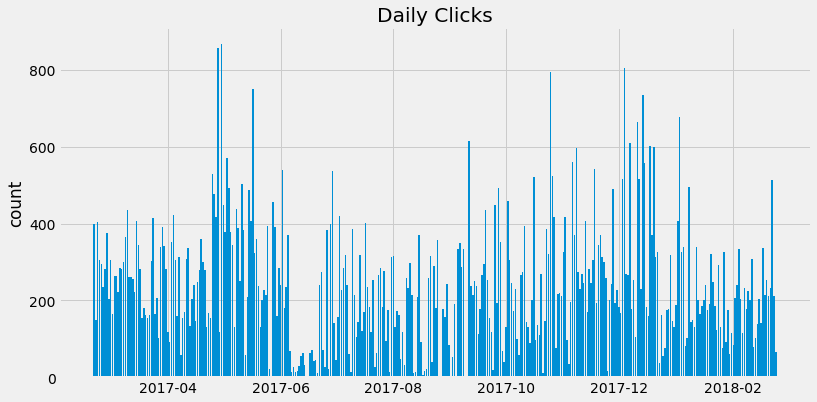

In [13]:
fig, ax = plt.subplots(figsize=(12, 6));
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2));
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'));
plt.ylabel('count');
plt.title('Daily Clicks');
plt.bar(daily['index'], daily['clicks']);

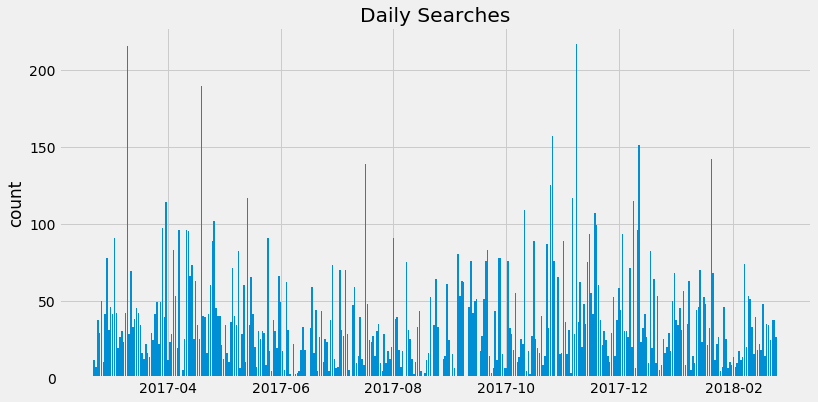

In [14]:
fig, ax = plt.subplots(figsize=(12, 6));
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2));
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'));
plt.ylabel('count');
plt.title('Daily Searches');
plt.bar(daily['index'], daily['search']);

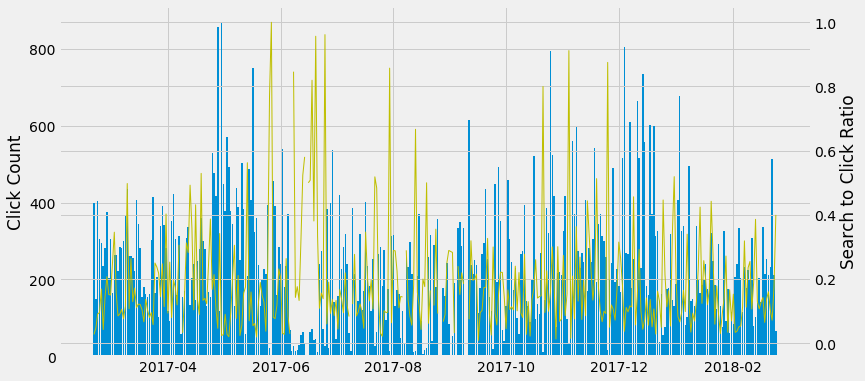

In [15]:
fig, ax = plt.subplots(figsize=(12, 6));
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=2));
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'));


plt.bar(daily['index'], daily['clicks']);
plt.ylabel('Click Count');

ax2 = ax.twinx();
ax2.plot(daily['index'], daily['search']/daily['clicks'], color='y',linewidth=1);
ax2.set_ylabel('Search to Click Ratio');

## Weekend vs Weekday

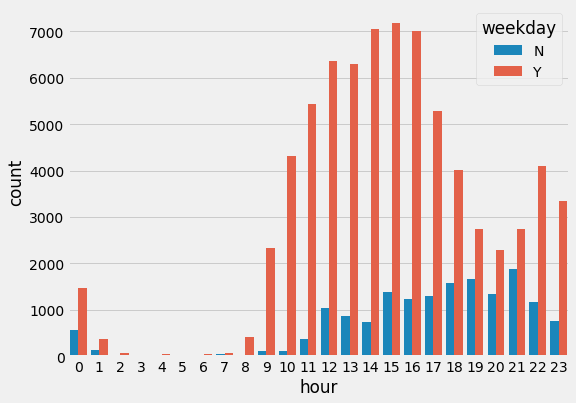

In [16]:
plt.figure(figsize = (8,6));
sns.countplot(x='hour', hue='weekday', data=df2);

# same plot using matplotlib
# df2.groupby(['hour','weekday']).size().unstack().plot.bar(figsize=(8,6))

## Browsing by Month

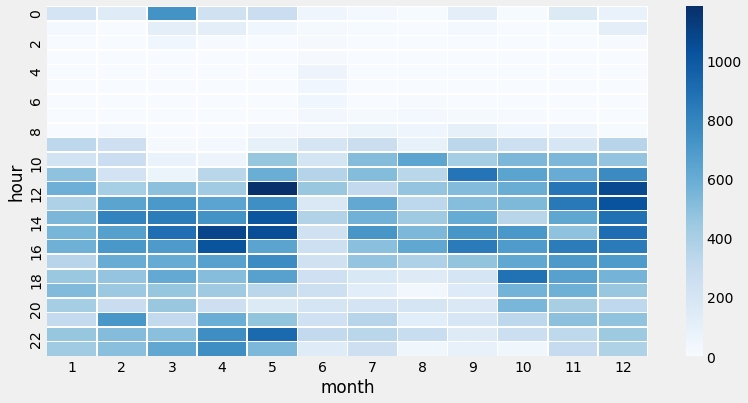

In [17]:
pivot_table = df2.groupby(['hour', 'month']).size().unstack('month', fill_value=0)
pivot_table;
plt.figure(figsize=(12,6));
sns.heatmap(pivot_table, linewidths=.5, annot=False, cmap='Blues');

## Browsing by Day of Week

In [19]:
pivot_table2 = df2.groupby(['hour', 'day_of_week']).size().unstack('day_of_week', fill_value=0)
pivot_table2 = pivot_table2[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

In [20]:
pivot_table3 = df2.groupby(['day_of_week','category']).size().unstack('day_of_week', fill_value=0)
pivot_table3 = pivot_table3[["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]]

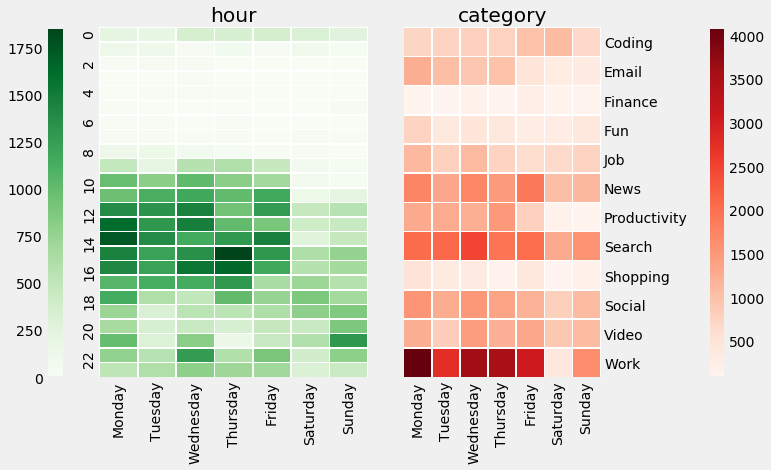

In [21]:
fig, (ax1,ax2) = plt.subplots(figsize=(12,6), ncols=2);
fig.subplots_adjust(wspace=0.1);

sns.heatmap(pivot_table2, linewidths=.5, ax=ax1, annot=False, cbar=False, cmap='Greens');
sns.heatmap(pivot_table3, linewidths=.5, ax=ax2, annot=False, cbar=False, cmap='Reds');
fig.colorbar(ax1.collections[0], ax=ax1,location="left", use_gridspec=False);
fig.colorbar(ax2.collections[0], ax=ax2,location="right", use_gridspec=False, pad=0.3);

ax1.xaxis.label.set_visible(False);
ax2.xaxis.label.set_visible(False);
ax1.yaxis.label.set_visible(False);
ax2.yaxis.label.set_visible(False);

ax2.yaxis.tick_right();
ax2.tick_params(axis='y',rotation=0);

ax1.set_title('hour');
ax2.set_title('category');

## Categories by Month

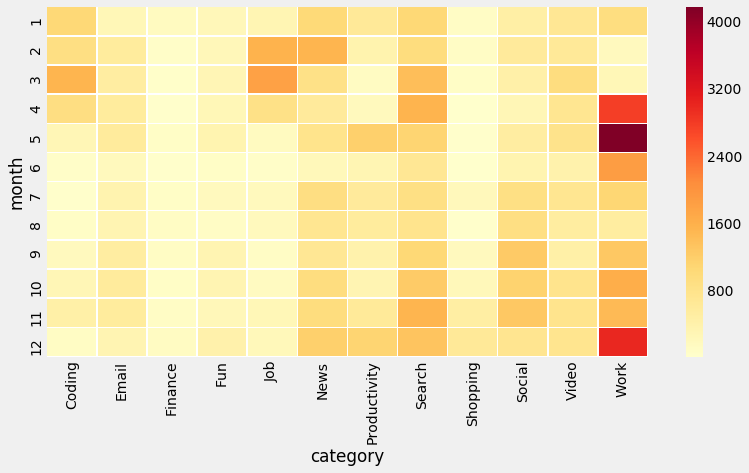

In [22]:
pivot_table4 = df2.groupby(['month','category']).size().unstack('category', fill_value=0)

plt.figure(figsize=(12,6));
sns.heatmap(pivot_table4, linewidths=.5, annot=False, cmap='YlOrRd');

## Word Cloud of Search History

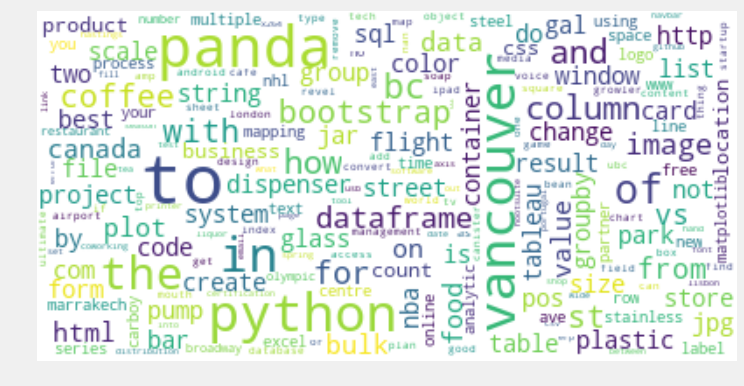

In [26]:
from collections import OrderedDict
search = df2[df2['category']=='Search']['title'].str.lower() \
        .str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ');

search_title = " ".join(search);
stopwords = ['google', 'search', 'stack', 'overflow', 'wikipedia', 'maps', 'v5z 3g5', 'v5z', '3g5', 'ash']
wc1 = WordCloud(stopwords=stopwords, max_font_size=40, collocations=False, regexp=None, background_color="white")\
            .generate(search_title);

# Display the generated image:
plt.figure(figsize=(12,6));
plt.imshow(wc1, interpolation='bilinear');
plt.axis("off");
plt.margins(x=0, y=0);

## Word Cloud of Domain Visits

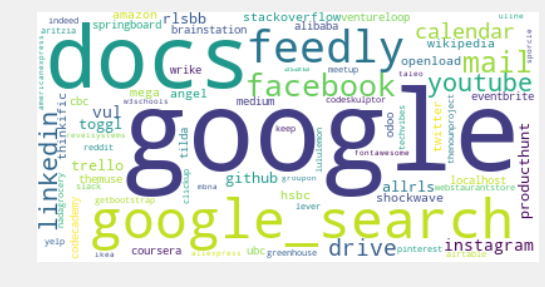

In [27]:
#from collections import OrderedDict
domains = df2['domain'].str.lower() \
        .str.split().apply(lambda x: OrderedDict.fromkeys(x).keys()).str.join(' ');

domain_title = " ".join(domains);
stopwords = [];
wc2 = WordCloud(stopwords=stopwords, collocations=False, regexp=None, background_color="white").generate(domain_title);

# Display the generated image:
plt.figure(figsize=(8,6));
plt.imshow(wc2, interpolation='bilinear');
plt.axis("off");
plt.margins(x=0, y=0);

## References:

* https://seaborn.pydata.org/api.html
* https://chrisalbon.com/python/data_visualization/seaborn_color_palettes/
* https://github.com/daerty0153/visualize-browser-history/blob/master/BrowserHistory.ipynb